In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/03_adaptiveCA')

import numpy as np
import matplotlib.pyplot as plt

import torch

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from models.NCA import CA, totalistic
import pygame
from src.utils import *

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


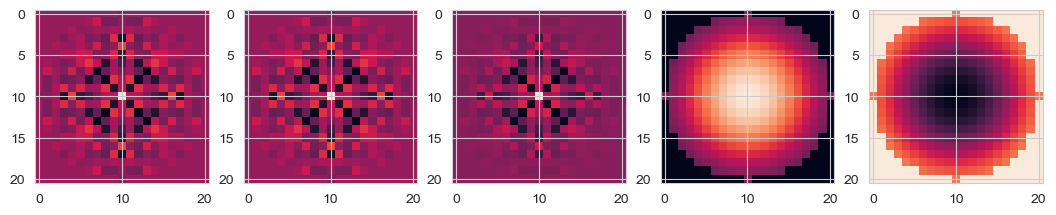

In [2]:
CHANNELS=6 # number of channels in grid
FILTERS=30 # number of filters per channel
HIDDEN=10 # number of hidden neurons

RADIUS=10 # radius of kernel
KCENTER=0. # radius of gaussian ring
KSMOOTH=0.9 # gaussian smoothing
OUTR=1. # outer ring of kernel
INR=0.  # inner ring of kernel
GAMP=-.1 # growth kernel amplitude


ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 


fig, ax = plt.subplots(1, 5, figsize=(13, 2.5))
ax[0].imshow(ca.rule.filter1[0, 0].cpu().detach().numpy())
ax[1].imshow(totalistic(ca.rule.filter1.detach())[0, 0].cpu().detach().numpy())
ax[2].imshow(totalistic(ca.rule.filter1 * ca.rule.decay_kernel)[0, 0].cpu().detach().numpy())
ax[3].imshow(ca.rule.decay_kernel.cpu().detach().numpy())
ax[4].imshow(ca.rule.growth_kernel.cpu().detach().numpy())

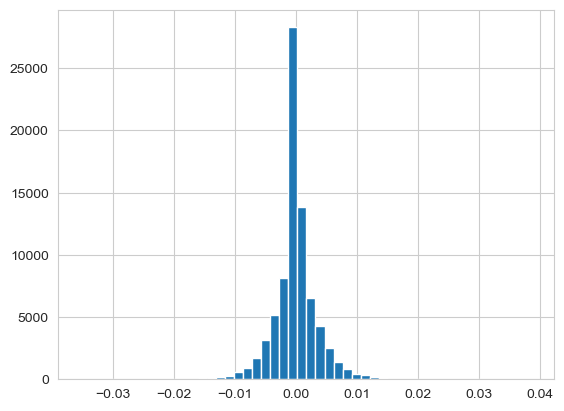

In [3]:
plt.hist((totalistic(ca.rule.filter1.detach()).cpu().detach().numpy()).reshape(-1), 50);

In [4]:
# brush properties
r = 40
s = 1

In [8]:
# resolution of grid
RESX=128
RESY=128

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 5
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
brush_toggle = False
WHEEL_trigger = False
cdim_order = np.arange(0, CHANNELS)

growth_kernel = False

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)

# CENTER SEED
seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
seed[:, :, RESX//2, RESY//2] = 1

# NOISE SEED
# seed = torch.randn(1, CHANNELS, RESX, RESY).cuda()
state = seed.clone()


update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []


with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            '''
            Keyboard shortcuts
            - [ and ] to change update rate
            - space to pause
            - e to export images
            - o to save current state as png
            - s to sink
            - p to pause
            - r to reset
            - t to toggle totalistic
            - g to toggle growth kernel
            '''
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -0.1
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += 0.1
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                    
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # pick another random CA
                ca = CA(CHANNELS=CHANNELS, FILTERS=FILTERS, HIDDEN=HIDDEN,
                        RADIUS=RADIUS, KCENTER=KCENTER, KSMOOTH=KSMOOTH, OUTR=OUTR, INR=INR, GAMP=GAMP).cuda() 
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if (event.type== pygame.KEYDOWN and event.key == pygame.K_o):
                # save current state as png
                timestr = time.strftime("%Y%m%d-%H%M%S")
                pygame.image.save(upscaled_screen, f"../figures/NCA_R_{RADIUS}_FILTERS_{FILTERS}_CHANNELS_{CHANNELS}_{timestr}.png")
            if event.type== pygame.KEYDOWN and event.key == pygame.K_t:
                ca.rule.totalistic = not ca.rule.totalistic
                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_g:
                ca.rule.use_growth_kernel = not ca.rule.use_growth_kernel

            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking

                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = seed.clone()
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = click(state, rmb=False, r=r, s=s, upscale=UPSCALE, brush_toggle=brush_toggle)
        if RMB_trigger:
            state = click(state, rmb=True, r=r, s=s, upscale=UPSCALE, brush_toggle=brush_toggle)
        
        
        # scroll to permute through which channels get visualized
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction, CHANNELS)
            WHEEL_trigger = False
            
        nx = state.cpu()[:, cdim_order].numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = nx*255.
        # nx = nx + 128
#         nx = (nx + 1)/2 * 255
#         nx = nx.astype(np.uint8)
        if time_ticking:
            # state = ca.forward_perception(state, dt=update_rate)
            # state = ca.forward_masked(state)
            state = ca.forward(state, update_rate=update_rate)
            ticker += 1
    
            if sink:
                #state[:, :, 0*RESX//10:10*RESX//10, 4*RESY//10:6*RESY//10] = torch.cuda.FloatTensor([-127. * np.sin(ticker / 20.)])
                # state[:, :, 4*RESX//10:6*RESX//10, 4*RESY//10:6*RESY//10] += - 0.1 * torch.cuda.FloatTensor([-127. * np.sin(ticker / 100.)])
                state[:, :, 4*RESX//10:6*RESX//10, 4*RESY//10:6*RESY//10] *= 0.8

            if export_imgs and time_ticking:
                imgs.append(nx)

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        # upscaled_screen.blit(update_fps(clock, font), (10,0))
        # upscaled_screen.blit(show_param_info(update_rate, 'update_rate'), (RESXup - 100,0))
        pygame.display.flip()
        clock.tick()
        
pygame.quit()


In [ ]:
nx

In [ ]:
plt.hist(state.cpu().detach().numpy().reshape(-1));